In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [7]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
len(words)

32033

In [9]:
# sort list of characters from a to z
chars = sorted(list(set(''.join(words)))) 
# map characters to integers
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
# reverse mapping
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [10]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        # print(ix)
        X.append(context)
        # print(X)
        Y.append(ix)
        # print(Y)
        # print("....")
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [11]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [12]:
def build_dataset(words):  
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [13]:
C = torch.randn((27, 2))
emb = C[X]
emb.shape
### There are 32 training samples with 3 characters each and each of the characters have 2-d embedding

torch.Size([228146, 3, 2])

In [14]:
# F.one_hot(torch.tensor(5), num_classes=27).float()

In [15]:
# F.one_hot(torch.tensor(5), num_classes=27).float() @ C

In [16]:
# # the 2-d embedding of every word is concatenated one after the other 
# # for each of the 32 examples 
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

In [17]:
# ## In the above code we had entered the 0, 1 and 2 manually for block size 3
# ## To generalize the code for any block size, use the foll
# torch.cat(torch.unbind(emb, 1), 1).shape

In [18]:
W1 = torch.randn((6, 100))
b = torch.randn(100)

# hidden representation
h = torch.tanh(emb.view(-1, 6) @ W1 + b)
h.shape

torch.Size([228146, 100])

In [19]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [20]:
counts = logits.exp()
counts.shape

torch.Size([228146, 27])

- **`sum(1, keepdims=True)`**: Used when the tensor is 2D, and you want to sum over the columns (dimension 1), keeping the row dimension.
- **`sum(0, keepdim=True)`**: Used when the tensor is 1D, and you want to sum over the entire vector, keeping the resulting shape compatible for further operations.

In the direct indexing method, `counts` is a 1D tensor, so summing over dimension 0 is the correct operation. If you were to use `sum(1, keepdims=True)` in the direct indexing case, you'd get an error because there is no dimension 1 in a 1D tensor.


In [21]:
prob = counts / counts.sum(1, keepdims=True)

In [22]:
prob.shape

torch.Size([228146, 27])

In [23]:
prob[0].sum()

tensor(1.)

In [24]:
### Now made respectable ###

In [25]:
Xtr.shape, Ytr.shape    # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [26]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g, requires_grad=True)
W1 = torch.randn((30, 200), generator=g, requires_grad=True)
b1 = torch.randn(200, generator=g, requires_grad=True)
W2 = torch.randn((200, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [27]:
sum(p.nelement() for p in parameters)   # number of parameters in total

11897

In [28]:
for p in parameters:
    p.requires_grad = True

In [29]:
lre = torch.linspace(-3, 0, 1000) # lre: linear rate exponent
lrs = 10**lre

In [30]:
lr_i = []
loss_i = []
step_i = []

In [32]:
for i in range(50000):
    # lr = lrs[i]

    # Define optimizer
    optimizer = torch.optim.SGD(parameters, lr=0.01)

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix]) # much more efficient and numerically well behaved
    
    # # backward pass
    # for p in parameters:
    #     p.grad = None

    # loss.backward()
    
    # # update
    # for p in parameters:
    #     p.data += -0.1 * p.grad

    # Zero gradients
    optimizer.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()

    # track stats
    # lr_i.append(lre[i])
    step_i.append(i)
    loss_i.append(loss.log10().item())

print(loss.item())

2.310551881790161


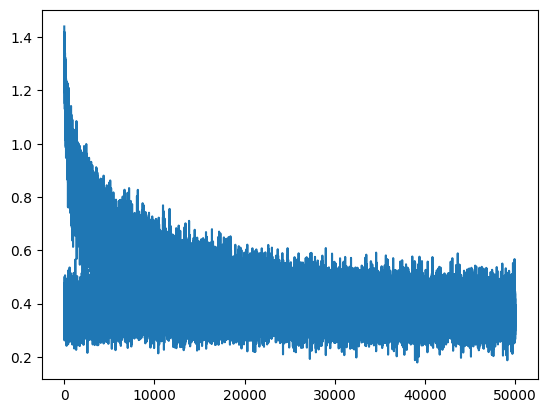

In [33]:
plt.plot(step_i, loss_i)

In [34]:
# plt.plot(lr_i, loss_i)

In [35]:
emb = C[Xtr]  
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3271, grad_fn=<NllLossBackward0>)

In [36]:
emb = C[Xdev]  
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3343, grad_fn=<NllLossBackward0>)

In [37]:
# # visualize dimensions 0 and 1 of the embedding matrix C for all characters
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')

In [39]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [40]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayannieel.
ndhayla.
rethan.
jadrlee.
azered.
eliighay.
jenleighavananar.
kayzimolka.
cayshaberghai.
jest.
juliwalliranterof.
uva.
gedt.
jamili.
eha.
kaysh.
salyan.
hyl.
salyansun.
